In [1]:
import numpy as np
import matplotlib.pyplot as plt
import funky as f
import scipy
rng=np.random.default_rng(seed=1)

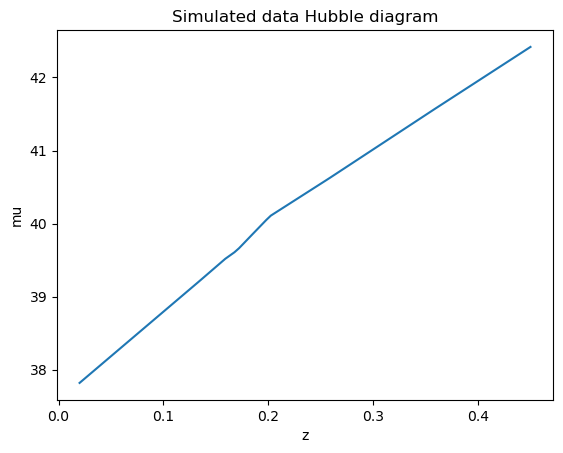

In [2]:
mu, zhd= f.sim_wrapper([0.34,-1],'prova')
z_sim,mu_sim=(f.smoother(zhd,mu))

plt.plot(z_sim,mu_sim)
plt.title('Simulated data Hubble diagram')
plt.xlabel('z')
plt.ylabel('mu')
plt.show()

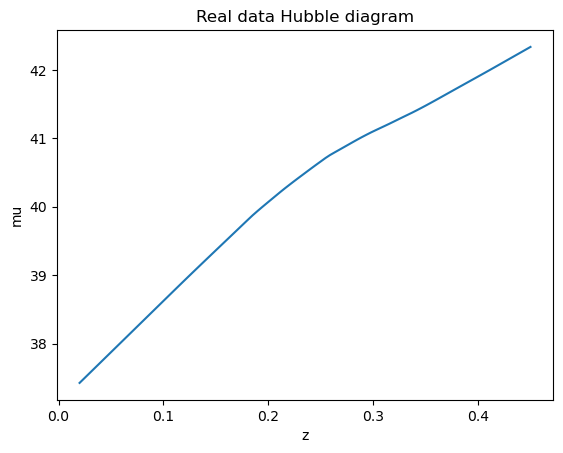

In [3]:
mu_data,z_data=f.extract_mu_zhd_from_file('/home/ubuntu/SNANA/SNROOT/realdata_fit/real.FITRES')
# summary statistic of real data
z_data,mu_data=(f.smoother(z_data,mu_data))

plt.plot(z_data,mu_data)
plt.title('Real data Hubble diagram')
plt.xlabel('z')
plt.ylabel('mu')
plt.show()

In [15]:
# errore si deve aggiornare a ogni trial
# observed data: nel paper sono 200 sampled SNe con omega m =0.27 e w = -1. Ho=72 km s-1 mpc-1.
N=50   


w=np.repeat(1/N,repeats=N)
theta_1=[]
distances=[]

#iterazione t = 1
while len(theta_1)<N:

    # Sample from prior: uniform over 0 < omega < 1, -3 < w < 0.
    theta=np.array([rng.uniform(0,1), rng.uniform(-3,0)])

    # simulate z and mu given choice of theta
    mu_1, z_1= f.sim_wrapper(theta,'prova')
    z_1,mu_1=(f.smoother(z_1,mu_1))

    # compute delta from summary stat. of real data
    delta = np.median(np.abs(mu_data - mu_1))

    # build array
    theta_1.append(theta)
    distances.append(delta)
# final array of 500 particles to perturb.    
theta_t=np.array(theta_1)

# TAU
tau_square=2*np.cov(theta_t, rowvar=False)

In [31]:
print('percentile 75', np.percentile(distances, q=75))
print('median distance initial: ', np.median(distances))
print('min: ',np.min(distances))
print('max: ',np.max(distances))



percentile 75 0.1029047216140686
median distance initial:  0.08296710298108145
min:  0.03510326171424438
max:  0.18231699764297815


tau square:  [[ 0.14300872 -0.11764945]
 [-0.11764945  1.58201322]]


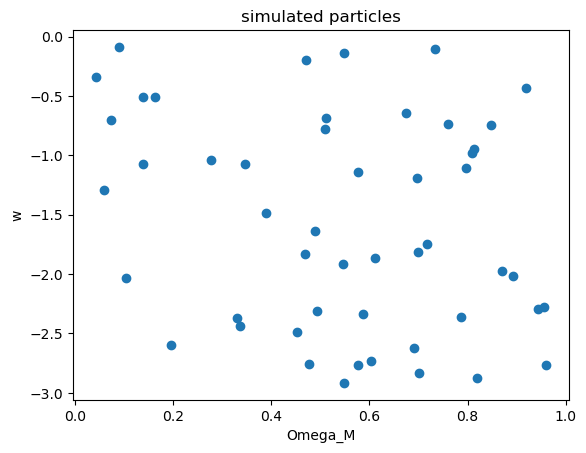

In [17]:
print('tau square: ',tau_square)

plt.scatter(theta_t[:,0],theta_t[:,1])
plt.title('simulated particles')
plt.xlabel('Omega_M')
plt.ylabel('w')
plt.show()

In [32]:
tau_square=2*np.cov(theta_t, rowvar=False)
tau_square

array([[ 0.14300872, -0.11764945],
       [-0.11764945,  1.58201322]])

In [33]:
print(np.percentile(distances,q=75))

0.1029047216140686


In [34]:
epsilon_t = np.percentile(distances,q=75)
print('starting epsilon: ',epsilon_t)
k=0
#for t in range(2,T):
while epsilon_t > 0.033:
    k+=1
    print('start iteration',k)
    theta_new=[] # diventerà il nuovo theta_t
    weights_new=[] # diventeranno il nuovo w
    distances_new=[]

    # Voglio N particles che mi piacciono. Alla fine aggiornerò pesi e epsilon
    for i in range(N):
        print('N=',i)
        while True:
            # sample particle
            idx=rng.choice(range(N),p=w)
            theta_star=theta_t[idx]
            #perturb particle!
            theta_i_t=rng.multivariate_normal(theta_star, tau_square) # propongo un aggiornamento di un theta
            # scarto se sono fuori dal dominio
            if not ((0<theta_i_t[0]<1) and (-3<theta_i_t[1]<0)): continue
            #print(theta_i_t)
            # simulate z and mu given choice of theta
            mu_i_t, z_i_t= f.sim_wrapper(theta_i_t,'prova')
            z_i_t,mu_i_t=(f.smoother(z_i_t,mu_i_t))

            # create summary statistics
            _,mu_i_t=f.smoother(z_i_t,mu_i_t)

            # compute distance from summary stat. of real data
            delta = np.median(np.abs(mu_data - mu_i_t))
            print('delta proposto: ',delta)
            if delta<epsilon_t:
                print('accettato',theta_i_t)
                break  #Ho trovato una particle che mi piace.
            else: print('rifiutato')
        
        theta_new.append(theta_i_t)
        distances_new.append(delta)

        # aggiorna pesi ---- DA RICONTROLLARE
        denom = 0.0
        for j in range(N):
            denom += w[j] * scipy.stats.multivariate_normal.pdf(x=theta_i_t,mean=theta_t[j],cov=tau_square)
        weight = 1 / denom
        weights_new.append(weight)


    ### Ora ho N particles che mi piacciono. Aggiorno tutto

    print('new theta done! Iteration',k)
    # w update
    weights_new=np.array(weights_new)
    w = weights_new / np.sum(weights_new)

    # theta_t update
    theta_t=np.array(theta_new)
    
    #epsilon update
    epsilon_t= np.percentile(distances_new,q=50)
    print('epsilon: ',epsilon_t)
# è finita. Ho il mio vettore theta di 500 particelle che seguono la posterior.
tau_square=2*np.cov(theta_t.T,aweights=w,bias=False)

starting epsilon:  0.1029047216140686
start iteration 1
N= 0
delta proposto:  0.06918127084058057
accettato [ 0.4494069  -1.49611754]
N= 1
delta proposto:  0.06603934866248906
accettato [ 0.0529023  -0.52610022]
N= 2
delta proposto:  0.062384419672692815
accettato [ 0.55044987 -1.84377965]
N= 3
delta proposto:  0.09522705542116938
accettato [ 0.43361987 -2.24468893]
N= 4
delta proposto:  0.07133892255500385
accettato [ 0.92211129 -1.5185218 ]
N= 5
delta proposto:  0.08122641856708412
accettato [ 0.68980474 -1.69051802]
N= 6
delta proposto:  0.08398515431439435
accettato [ 0.939457   -0.81005171]
N= 7
delta proposto:  0.08115733653302115
accettato [ 0.63600646 -1.57077856]
N= 8
delta proposto:  0.09886195257232444
accettato [ 0.74430962 -2.08994173]
N= 9
delta proposto:  0.045023457047591364
accettato [ 0.68458884 -1.49477156]
N= 10
delta proposto:  0.0653706619544181
accettato [ 0.52916621 -1.14307006]
N= 11
delta proposto:  0.12192934073262052
rifiutato
delta proposto:  0.061525818772

KeyboardInterrupt: 

In [11]:
print(theta_t)
print(tau_square)

[[ 0.57505281 -0.4276333 ]
 [ 0.69468087 -1.87558391]
 [ 0.15702855 -0.5475967 ]
 [ 0.87711815 -2.25063952]
 [ 0.05985596 -0.41395926]
 [ 0.73317995 -2.91445791]
 [ 0.99523566 -0.52953618]
 [ 0.01799195 -2.48415923]
 [ 0.07120963 -2.64615151]
 [ 0.28888034 -2.1815705 ]
 [ 0.17111629 -0.63571071]
 [ 0.1447651  -1.52426673]
 [ 0.40629961 -1.25519894]
 [ 0.45285052 -2.03558486]
 [ 0.27049558 -0.6261278 ]
 [ 0.39544327 -1.71814344]
 [ 0.3642093  -2.01356854]
 [ 0.67497412 -0.63612491]
 [ 0.38815429 -1.30241179]
 [ 0.60266341 -0.63283344]
 [ 0.40559424 -1.89360573]
 [ 0.56293506 -2.86509016]
 [ 0.39256964 -2.29291094]
 [ 0.62702356 -1.88216425]
 [ 0.20156115 -1.54688083]
 [ 0.76603798 -0.83856351]
 [ 0.80098594 -2.1314368 ]
 [ 0.70455318 -2.85281957]
 [ 0.33906596 -2.50506113]
 [ 0.1835316  -2.94399167]
 [ 0.8984206  -2.86018824]
 [ 0.76516954 -2.90304183]
 [ 0.74698077 -1.51441761]
 [ 0.42913984 -2.05715428]
 [ 0.83358066 -2.81903037]
 [ 0.39563814 -2.36798736]
 [ 0.11787867 -0.61023294]
 

## TRASH

In [ ]:
#### simulazione dummy di z_phot, z_spec per 1744 SNe

z_spec=rng.uniform(0,0.45,size=1744)
z_phot=z_spec+ rng.normal(0.001,0.05,size=1744)
z_phot[z_phot<0]=0.001
z_phot[z_phot>0.45]=0.45
plt.scatter(z_spec,z_phot,c='orange')
plt.xlabel('spec z')
plt.ylabel('photo z')
plt.show()

In [ ]:
# snana per simulare sets di supernovae da diverse cosmologie.

#
# collezione di  500 particelle, viene migrata nel corso dell'algoritmo.
# poi scelgo a random una particella e la perturbo. Simulation data: 200 (z,z') pairs, sampling
# with replacement, da collezione di 500 particelle sopra. Con 200 true redshifts e theta i specificato
# allora calcoliamo il modulo di distanza. Aggiungiamo incertezza usando una Gaussian PDF con sigma= 0.04.
# gli observable data comprise the xti that appear nell'algoritmo. #

# summary statistic: applico un nonparametric regression smoother (5b), check appendice


# real data: per ogni curva, prendiamo 7 punti, prendiamo 103 sne sdss.
# simulated data: selection cuts e misuro il distance modulus.

# similarity delta: facciamo smooth dei due datasets e poi la median absolute deviation.
# fissiamo H0 a 65
# epsilon t: varia da iterazione a iterazione
# scegliamo N=150 particles e facciamo runnare il codice.




# Praticamente (z,z') mi serve solo nel primo esempio finto. 
# Mentre nell'altro caso, quello che vogliamo fare noi, penso lo faccia SNANA di simularsi un 
# redshift dalla power law.#

#            idx_z=rng.choice(range(z_phot),size=200,replace=True)
#            z_spec_i=z_spec[idx]
#            z_phot_i=z_phot[idx]


In [4]:
from astropy.io import fits
import pandas as pd

# Apri il file HEAD delle Supernovae
path='/home/ubuntu/SNANA/SNROOT/lcmerge/SDSS_allCandidates+BOSS/SDSS_allCandidates+BOSS_HEAD.FITS'
with fits.open(path) as hdul:
    data = hdul[1].data  # Di solito i dati sono nel primo HDU dopo l'header
    # Crea un DataFrame con le colonne che ti servono
    df = pd.DataFrame({
        'SNID': data['SNID'],
        'z_helio': data['REDSHIFT_HELIO'],
        'z_cmb': data['REDSHIFT_FINAL'],
        
    })
    #df=pd.DataFrame(data)

# Ora hai tutti i dati reali pronti per essere confrontati con le simulazioni
df.head(15)
print(hdul[1])

In [11]:
len(z_real)

260